In [1]:

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
os.environ['TF_ENABLE_CUDNN_OPTS'] = '0'
os.environ['DEEPREG_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from ipylab import JupyterFrontEnd
import sklearn
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
print('sklearn : ', sklearn.__version__)
print('cv2 : ', cv2.__version__)
print('tf : ', tf.__version__)
print('np : ', np.__version__)

sklearn :  1.5.2
cv2 :  4.10.0
tf :  2.16.1
np :  1.26.4


In [3]:
class video_convert:

    def __init__(self,path_video_dir, file_type, path_data_save, trget_nr_fremes, trget_width, trget_height):
        self.path_video_dir = path_video_dir # input videos dir
        self.file_type = file_type
        self.path_data_save = path_data_save # dir data save 
        self.trget_nr_fremes = trget_nr_fremes
        self.trget_width = trget_width
        self.trget_height = trget_height
        
        
        # creates the list of directories where the files are located
        self.list_label_name = sorted(os.listdir(self.path_video_dir))
        print(self.list_label_name)

        # creates a list of numbers equivalent to labels
        self.list_label_categorical = range(len(self.list_label_name))
        # creates categorical value of labels
        self.list_label_categorical = to_categorical(self.list_label_categorical, num_classes = len(self.list_label_name))
        print(self.list_label_categorical)

        self.save_data()


    # method
    # -list of paths to videos
    # - label matrix
    def list_video_path_and_labels(self):


        Y = []
        
        # initialize the list of paths to *.avi 
        self.X_video_path = []

        # iterate the list
        for dir_label in self.list_label_name:
            
            #iterate over files in dir_label
            for path_video in os.listdir(self.path_video_dir + '/' + dir_label):
                
                # check if the file has the desired extension
                if path_video.endswith(self.file_type):
                    
                    # add to the list, paths to *.avi
                    self.X_video_path.append(self.path_video_dir + '/' + dir_label + '/' + path_video)
                    
                    # from the list self.list_label_name extract the index corresponding to dir_label 'indexul =self.list_label_name.index(dir_label)'
                    # with the obtained index,                                                           = 'self.list_label_categorical[indexul]' 
                    Y.append(self.list_label_categorical[self.list_label_name.index(dir_label)])

        # transform list into array
        self.Y = np.array(Y, dtype=np.uint8)
        print('labels : ', self.Y.shape)

    # metoda
    # - extract the desired number of frames
    # - call 'apply_pad_img()' to create the desired format
    # - convert the original frames to the desired format
    # - create the dataset with the processed movies
    def video_pre_processing(self):

        self.list_video_path_and_labels()

        # determines the ratio between the desired image width and its desired height
        target_ratio = self.trget_width / self.trget_height

        videos = []
        for X_video in self.X_video_path:
            
            # determine the characteristics of the video
            capture = cv2.VideoCapture(X_video)                          # create the CV object
            total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))    # extract total number of frames
            width_capture = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   # extract image width value
            height_capture = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) # extract image height value
            #fps = capture.get(cv2.CAP_PROP_FPS)                          # extrage valoarea numarului de cadre pe secunda
                                               
        
            # the target running pitch is determined
            step = total_frames / self.trget_nr_fremes
            
            # generates the list of frames to be extracted from total frames
            list_fremes = []
            for i in range(self.trget_nr_fremes):
                list_fremes.append(int(i*step))
                
            # if the value (index) in list_fremes is greater than the value of the last index in 'capture' (total_frames - 1), 
            # correct the last index with total_frames - 1
            if list_fremes[-1] > total_frames - 1:
                list_fremes[-1] = total_frames -1


            # extract frames from the list (list_fremes)
            frames_list = []
            for i in list_fremes:
                # sets the frame to be retrieved
                capture.set(cv2.CAP_PROP_POS_FRAMES,i)
                # returns a bool (true/false). If the frame is read correctly, it will be success=True.
                # .read() returns the set image capture.set(cv2.CAP_PROP_POS_FRAMES,nr)
                success, frame = capture.read()
            
                # if success = False abandon the video
                if not success:
                    print('errrr')
                    err = 1
                    break


                # Convert from BGR to RGB
                frame=cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

                # applies zeros to the edges of the image so as to generate the desired ratio
                frame=self.apply_pad_img(frame, width_capture, height_capture, target_ratio)

                # resize the image according to the desired resolution
                frame = cv2.resize(frame, (self.trget_width, self.trget_height))

                # add each frame of the video
                frames_list.append(frame)

            # add each video   
            videos.append(frames_list)
            
            # deactivate the object 'capture'
            capture.release()
            # destroy the cv2 window
            cv2.destroyAllWindows()
        
        
        self.X = np.array(videos, dtype=np.uint8) 
        print('videos : ', self.X.shape)


        
    def apply_pad_img(self,frame, width_capture, height_capture, target_ratio):

        # in cazul in care latimea este mai mare decat inaltimea
        if width_capture / height_capture > target_ratio:
            # determine the equivalent height for target_ratio
            height = int(width_capture / target_ratio)
            # generates the pad (with target_ratio ratio) on which the image is mounted
            pad_img = np.zeros((height,width_capture,3), dtype=np.uint8)
            # center the image on the height for the pad
            start = int((height - height_capture) / 2)
            end = start + height_capture
            # apply the image to the pad
            pad_img[start:end,:,:]=frame


            # if the width is less than the height
        elif width_capture / height_capture < target_ratio:
            # determine the equivalent width for target_ratio
            width = int(height_capture * target_ratio)
            # generates the pad (with target_ratio ratio) on which the image is mounted 
            pad_img = np.zeros((height_capture,width,3), dtype=np.uint8)
            # center the image on the pad width
            start = int((width - width_capture)/2)
            end = start + width_capture
            # apply the image to the pad
            pad_img[:,start:end,:]=frame


            # if width / height = target_ratio
        else:
            # redimesioneaza imaginea in functie de rezolutia dorita
            pad_img = frame

        return pad_img



    def save_data(self):
        
        # launches the mouvis processing method into execution
        self.video_pre_processing()

        # deletes the directory and its contents to create the environment for the new dataset
        try:
            folder_path = self.path_data_save 
            shutil.rmtree(folder_path)
            print('The folder and its contents have been deleted.')
        except:
            print('The folder was not deleted.')

        # separates into training data and evaluation data
        x_train, x_val, y_train, y_val = train_test_split(self.X, self.Y, random_state=31, test_size=0.2, train_size=0.8)
               
        print('x_train', x_train.shape)
        print('y_train', y_train.shape)
        print('x_val', x_val.shape)
        print('y_val', y_val.shape)


        # saves training data
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
        path = os.path.join(self.path_data_save + '/' + 'train_dataset')
        tf.data.Dataset.save(train_dataset, path)


        # save validation data
        val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)) 
        path = os.path.join(self.path_data_save + '/' + 'val_dataset')
        tf.data.Dataset.save(val_dataset, path)

        # save small test data
        np.save('small_test_features.npy', x_val[0:5])
        np.save('small_test_labels.npy', y_val[0:5])

        
        # save tag names
        df_list_label_name = pd.DataFrame(self.list_label_name)
        df_list_label_name.to_csv(self.path_data_save + '/' + 'list_label_name.csv')

        self.test_dataset()




    def test_dataset(self):

        # generates a random number in the range 0 - no of data
        nr = np.random.randint(low = 0, high=self.X.shape[0], size=1, dtype=int)
        nr = nr[0]
        # print(nr)

        # extract the record according to the number
        video_print = self.X[nr]/255

      
        # lists the categorical value of shares
        print('categorical value of the label : ', self.Y[nr])

        # select position
        pozitia = (tf.argmax(self.Y[nr])).numpy()
        print(pozitia)

        # identify class name by position
        print(self.list_label_name[pozitia])

        # prints the resulting frames, with records no.
        plt.figure(figsize=(16,9)) 
        for i in range(10):
            plt.subplot(int(self.trget_nr_fremes/4)+1, 4, i+1)   
            plt.imshow(video_print[i,:,:,:])
            #plt.gray()
            plt.axis('off')
        plt.show()




        

['Drink', 'Picking', 'Push', 'Run', 'Throwing objects', 'boxing', 'lifting weights', 'receiving the phone', 'stand', 'walking on stairs', 'walking with flashlight', 'waving']
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
labels :  (6613, 12)
videos :  (6613, 10, 240, 320, 3)
The folder was not deleted.
x_train (5290, 10, 240, 320, 3)
y_train (5290, 12)
x_val (1323, 10, 240, 320, 3)
y_val (1323, 12)
categorical value of the label :  [0 1 0 0 0 0 0 0 0 0 0 0]
1
Picking


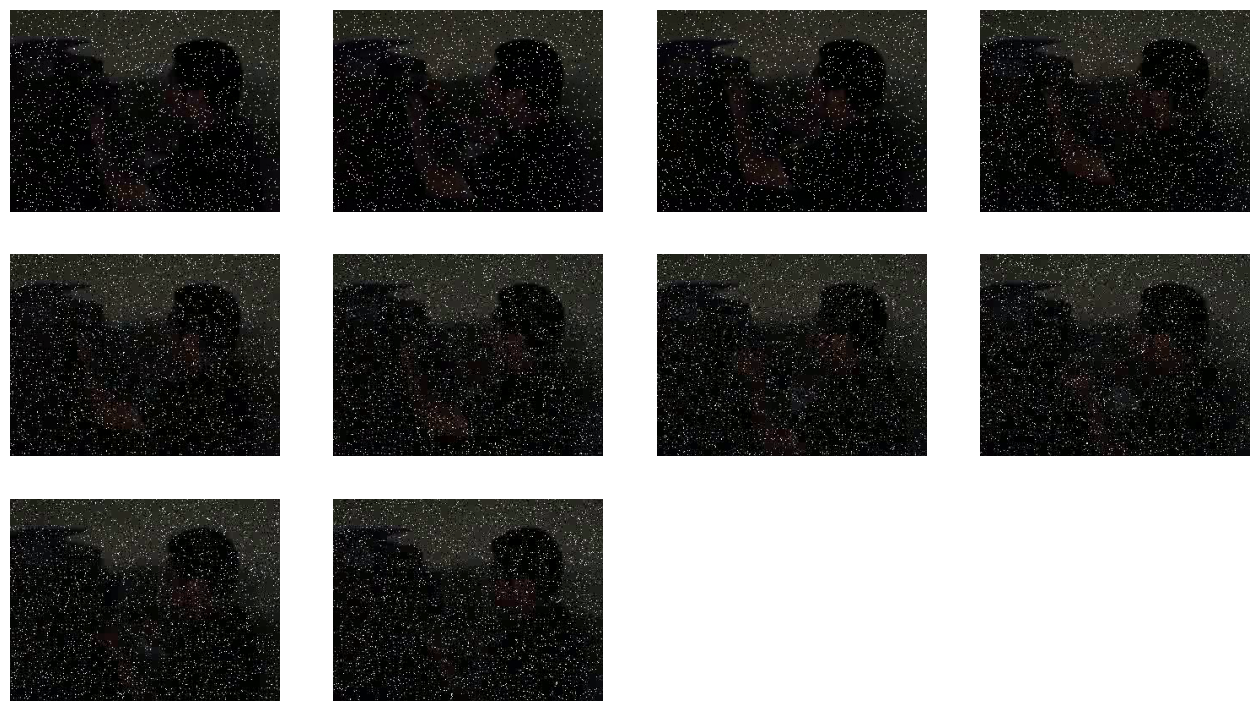

In [4]:
z = video_convert('modified_videos', '.mp4', 'dataset', 10, 320, 240)